In [6]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

### Cascading both model1 and model 2 together

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load BERT model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Set max sequence length
MAX_SEQ_LENGTH = 128

class Model:
    def load_model(self, load_path):
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        checkpoint = torch.load(load_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        print(f'Model loaded from <== {load_path}')
        return model

    def predict_sentiment(self, model, sentence):
        tokens = tokenizer.encode_plus(
            sentence,
            max_length=MAX_SEQ_LENGTH,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt')
        tokens = tokens.to(device)
        with torch.no_grad():
            outputs = model(tokens['input_ids'], token_type_ids=None, attention_mask=tokens['attention_mask'])
        logits = outputs[0]
        _, predicted = torch.max(logits, dim=1)
        return predicted.item()

    def predict_proba(self, data):
        # Load Model and Evaluate
        model1 = self.load_model('model_1.pt')
        model2 = self.load_model('model_2.pt')

        predictions=[]
        for post in data:
            result1=self.predict_sentiment(model1, post)
            if result1==0:
                predictions.append(0)
            else:
                result2=self.predict_sentiment(model2, post)
                if result2==0:
                    predictions.append(1)
                else:
                    predictions.append(2)
        return np.array(predictions)

# Instantiate the model
model = Model()


In [3]:
# Read dataset in CSV format and convert to pandas dataframe
test = pd.read_csv('test3.csv')

predictions = model.predict_proba(test['review'][:1000])

# Get user input for classification
accuracy = metrics.classification_report(test['label'][:1000], predictions, digits=3)
print('Accuracy of model cascade: \n')
print(accuracy)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== model_1.pt


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== model_2.pt
Accuracy of model cascade: 

              precision    recall  f1-score   support

           0      0.938     0.896     0.916       404
           1      0.868     0.810     0.838       284
           2      0.774     0.865     0.817       312

    accuracy                          0.862      1000
   macro avg      0.860     0.857     0.857      1000
weighted avg      0.867     0.862     0.863      1000



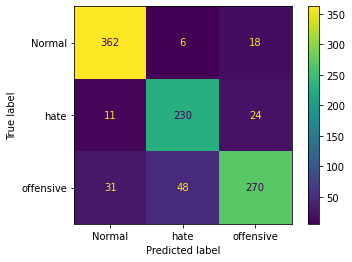

In [7]:
confusion_matrix = metrics.confusion_matrix(np.array(predictions),np.array(test['label'][:1000]))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Normal', 'hate','offensive'])
cm_display.plot()
plt.show()